In [1]:
!pip uninstall torchtext
!pip install torchtext
!pip install torchdata

Found existing installation: torchtext 0.14.0
Uninstalling torchtext-0.14.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/torchtext-0.14.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/torchtext/*
Proceed (y/n)? y
  Successfully uninstalled torchtext-0.14.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 18.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 40.4 MB/s 
     |████████████████████████████████| 140 kB 34.7 MB/s 
     |████████████████████████████████| 127 kB 80.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 446 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 33.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List

In [4]:
# text data preprocessing.

multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    
    train_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)


In [5]:
# model definition

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1, 
                 pre_ln=True):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout, 
                                       norm_first=pre_ln)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [6]:
# masking functions

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [7]:
# convert text pairs into tensors

from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [8]:
# experimental settings
from torch.utils.data import DataLoader

torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 4
FFN_HID_DIM = 1024
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 12
NUM_DECODER_LAYERS = 12
PRE_LN = False

# parameters for estimating Hessian spectrum
poly_deg            = 80  # the higher the parameter the better the approximation
poly_points         = 4096 # number of points in spectrum approximation
kappa               = 3    # contorls width of Gaussian bumps of spectrum

model = Seq2SeqTransformer(num_encoder_layers=NUM_ENCODER_LAYERS, 
                           num_decoder_layers=NUM_DECODER_LAYERS, 
                           emb_size=EMB_SIZE,
                           nhead=NHEAD, 
                           src_vocab_size=SRC_VOCAB_SIZE, 
                           tgt_vocab_size=TGT_VOCAB_SIZE, 
                           dim_feedforward=FFN_HID_DIM, 
                           pre_ln=PRE_LN)


for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)

train_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [11]:
# code for the Lanczos Algorithm for computing the Hessian

def ApproximateHessianSpectrum(title):
    model.eval()
    
    # Lanczos
    ritzVal, S, alpha, beta = Lanczos(poly_deg)
    
    # calculate lower bound (lb) and upper bound (ub) of spectrum
    theta_1 = ritzVal[0]
    theta_k = ritzVal[-1]
    
    s_1 = float(beta[-1]) * float(S[-1,0])
    s_k = float(beta[-1]) * float(S[-1,-1])
    
    lb = theta_1 - abs(s_1)
    ub = theta_k + abs(s_k)

    # pad a little bit the lower and upper bound
    margin = 0.05*(ub - lb)
    lb -= margin
    ub += margin

    # normalize eigenvalues to range [-1,1]
    c = (lb + ub)/2
    d = (ub - lb)/2
    ritzVal = (ritzVal - c) / d

    # width of Gaussian bumps
    H = 2 / (poly_deg - 1)
    sigma = H / np.sqrt(8 * np.log(kappa))
    width = sigma * np.sqrt(-2.0 * np.log(1e-08))

    # calculate spectrum approximation based on eigenvalues
    eigval = np.linspace(-1, 1, poly_points)
    diff = np.expand_dims(ritzVal,-1) - np.expand_dims(eigval,0)
    eigval_idx, pts_idx = np.where(np.abs(diff) < width)
    gamma2 = S[0,]**2
    vals = gamma2[eigval_idx]                                   \
         * np.exp(-((eigval[pts_idx] - ritzVal[eigval_idx])**2) \
         / (2 * sigma**2))
    density = np.zeros(poly_points)
    np.add.at(density, pts_idx, vals / np.sqrt((2 * sigma**2) * np.pi))
    
    # unnormalize spectrum approximation
    eigval = eigval*d + c
    density = density/d

    # plot spectrum
    plt.figure()
    plt.semilogy(eigval,density)
    plt.title(title)
    bottom, top = plt.ylim()
    plt.ylim((1e-20,top))

def Lanczos(M):
    p = sum(param.numel() for param in model.parameters() if param.requires_grad)
    # print(p)
    v = torch.randn(p).to(DEVICE)
    v /= torch.norm(v)
    
    alpha = torch.zeros(M).to(DEVICE)
    beta = torch.zeros(M).to(DEVICE)
    
    v_prev = None
    
    for m in range(M):
        print('Lanczos Iteration: [{}/{}]'.format(m+1, M))
        
        # TASK 1: ADD CODE HERE
        if m == 0:
          v_next = Hessian_vector_multiplication(v)
        else:
          v_next = Hessian_vector_multiplication(v) - beta[m - 1] * v_prev
        alpha[m] = v_next.T @ v
        v_next = v_next - alpha[m] * v
        beta[m] = torch.norm(v_next)
        v_next = v_next / beta[m]
        v_prev = v
        v = v_next

    B = np.diag(alpha.cpu().numpy()) + np.diag(beta.cpu().numpy()[:-1], k=1) + np.diag(beta.cpu().numpy()[:-1], k=-1)
    ritz_val, S = np.linalg.eigh(B)
    
    return ritz_val, S, alpha, beta

def list_to_vector(list_):
    return torch.cat([x.reshape(-1) for x in list_])

def vector_to_list(vector):
    list_ = []
    counter = 0
    for param in list(model.parameters()):
        list_.append(vector[counter:counter+torch.numel(param)].view(param.shape))
        counter += torch.numel(param)
    return list_

def Hessian_vector_multiplication(v):
    Hg = 0
    counter = 0
    
    for src, tgt in train_dataloader:
      src = src.to(DEVICE)
      tgt = tgt.to(DEVICE)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

      logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

      tgt_out = tgt[1:, :]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

      gradient = list_to_vector(torch.autograd.grad(loss, model.parameters(), create_graph=True))
      Hg += list_to_vector(torch.autograd.grad(gradient, model.parameters(), grad_outputs=v))

      counter += src.shape[0]
    
    return Hg / counter

Lanczos Iteration: [1/80]


<ipython-input-11-cfc060301e79>:75: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  alpha[m] = v_next.T @ v


Lanczos Iteration: [2/80]
Lanczos Iteration: [3/80]
Lanczos Iteration: [4/80]
Lanczos Iteration: [5/80]
Lanczos Iteration: [6/80]
Lanczos Iteration: [7/80]
Lanczos Iteration: [8/80]
Lanczos Iteration: [9/80]
Lanczos Iteration: [10/80]
Lanczos Iteration: [11/80]
Lanczos Iteration: [12/80]
Lanczos Iteration: [13/80]
Lanczos Iteration: [14/80]
Lanczos Iteration: [15/80]
Lanczos Iteration: [16/80]
Lanczos Iteration: [17/80]
Lanczos Iteration: [18/80]
Lanczos Iteration: [19/80]
Lanczos Iteration: [20/80]
Lanczos Iteration: [21/80]
Lanczos Iteration: [22/80]
Lanczos Iteration: [23/80]
Lanczos Iteration: [24/80]
Lanczos Iteration: [25/80]
Lanczos Iteration: [26/80]
Lanczos Iteration: [27/80]
Lanczos Iteration: [28/80]
Lanczos Iteration: [29/80]
Lanczos Iteration: [30/80]
Lanczos Iteration: [31/80]
Lanczos Iteration: [32/80]
Lanczos Iteration: [33/80]
Lanczos Iteration: [34/80]
Lanczos Iteration: [35/80]
Lanczos Iteration: [36/80]
Lanczos Iteration: [37/80]
Lanczos Iteration: [38/80]
Lanczos I

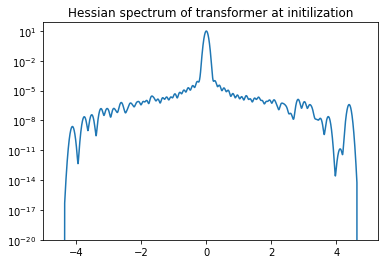

In [12]:
ApproximateHessianSpectrum('Hessian spectrum of transformer at initilization')
